In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from copy import deepcopy
from matplotlib.cm import get_cmap, ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from scipy import spatial
from sklearn.metrics import r2_score
import sys

sys.path.append('..')
from data_utils import *

sys.path.append('../../DeLASE')
from delase import *
from parameter_choosing import *
from performance_metrics import *

# Relevant Functions

In [3]:
def set_smallest_eigenvalue_real_part(A,lam):

    #lam is the desired maximum eigenvalue
    assert lam < 0, print('Eigenvalue must be negative')

    #get current eigenvalues
    e,v = np.linalg.eig(A)
    largest_eig = np.max(np.real(e))
    I = np.eye(len(e))
  
    #return scaled 
    return A - largest_eig*I + lam*I

def do_one_sde_run(n, lam_awake, lam_anesthesia, awake = 1):

    np.random.seed(42)

    A = np.random.normal(0,1/np.sqrt(n),(n,n))

    if awake == 1:
        #pick the stability parameter
        lam = lam_awake

        # Define the Weiner process    
        dW = np.sqrt(dt) * np.random.randn(N,n)

        #define systems matrix
        A_awake = set_smallest_eigenvalue_real_part(A,lam)

    else:

        lam = lam_anesthesia

        dW = np.sqrt(dt) * np.random.randn(N,n)

        A_anesthesia = set_smallest_eigenvalue_real_part(A,lam)


    # Define the function f(x)
    def f(x,lam):
        if awake == 1:
            return A_awake @ x
        else:
            return A_anesthesia @ x


    # Define the function g(x)
    def g(x):
        return 1

    # Initialize the x array
    x = np.zeros((N,n))
    x[0] = np.zeros(n)

    # Simulate the stochastic differential equation
    for i in range(1, N):
        x[i] = x[i-1] + f(x[i-1],lam) * dt + g(x[i-1]) * dW[i]

    return x

def compute_explained_variance(S):
    return torch.cumsum(S**2/((S**2).sum()), 0)

# Load Data

In [43]:
save_dir = '/scratch2/weka/millerlab/eisenaj/ChaoticConsciousness/temp'
system = 'chaotic'

In [47]:
# exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 0.9999])
exp_variance_vals = np.array([0.8, 0.85, 0.9, 0.95, 0.97, 0.98, 0.99, 0.999, 1 - 1e-4, 1 - 1e-6, 1 - 1e-8, 1- 1e-10, 1- 1e-12, 1 - 1e-14, 1])

if system == 'linear':
    # Define the parameters
    # N = int(1e5)
    N = 20000
    n = 100
    T = 40.0
    dt = T / N
    x0 = 0.0
    
    lams = [-1, -0.9, -0.8, -0.7, -0.6, -0.5, -0.4, -0.3, -0.2, -0.1]
    trajs = {}
    for lam in lams:
        x_1 = do_one_sde_run(n, lam_awake = lam, lam_anesthesia = 0, awake = 1)
        trajs[lam] = x_1
#         plt.plot(np.linspace(0, T, N), x_1[:,0], label = f'$\lambda_1(A) = {lam}$')
#     plt.legend()
#     plt.show()
    num_samples = 10
    indices = np.random.choice(np.arange(n), num_samples, replace=False)
    for key in trajs.keys():
        trajs[key] = trajs[key][:, indices]
        
    parameter_grid = ParameterGrid(
        window_vals=np.array([10000]),
        matrix_size_vals=np.array([10, 20, 50, 100, 200, 300, 500, 750, 1000]),
    )
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000])
    
    prediction_time = 5000
    transient = 2000
    
    save_file = 'results_linear_models_grid_search.pkl'
    
    signals = trajs
    
    mean_stab_curve = True
    true_vals = lams
    keys = np.array(lams)
    key_inds = np.arange(len(lams))

elif system == 'chaotic':
    chaotic_net_path = "/scratch2/weka/millerlab/eisenaj/DynamicalTrajectories/chaotic_net_data"

    W = pd.read_pickle(os.path.join(chaotic_net_path, "W.pkl"))
    lyaps = pd.read_pickle(os.path.join(chaotic_net_path, "lyaps_long.pkl"))
    full_signals = pd.read_pickle(os.path.join(chaotic_net_path, "chaotic_net_signals_long.pkl"))

    N = list(full_signals.values())[0].shape[2]
    T = list(full_signals.values())[0].shape[1]
    dt = 0.01

    noise_sd = 0.1
    # noise_sd = 0
    normalize = False
    # indices = np.random.choice(np. arange(N), size=(50,), replace=False)
    indices = pd.read_pickle(os.path.join(chaotic_net_path, "indices.pkl"))
    signals = {}
    for key in full_signals.keys():
        signals[key] = full_signals[key][0][:, indices] 
        if normalize:
            signals[key] = (signals[key] - signals[key].mean())/signals[key].std()
        signals[key] += np.random.randn(T, len(indices))*noise_sd
    
    parameter_grid = ParameterGrid(
        window_vals=np.array([10000]),
        matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000]),
    )
    
    r_vals = np.array([3, 5, 10, 25, 50, 75, 100, 125, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600, 650, 700, 750, 800, 900, 1000, 1200, 1400, 1600, 1800])
    
    prediction_time = 4000
    transient = 2000
    
    mean_stab_curve = True
    keys = np.array(list(signals.keys()))
    key_inds = [i for i in range(len(keys)) if keys[i] >= 1.1]
    true_vals = [lyaps[key][0] for key in keys[key_inds]]
    
    save_file = 'results_chaotic_models_grid_search_over_r.pkl'
    
elif system == 'neural':
#     session = 'MrJones-Anesthesia-20160109-01'
    session = 'Mary-Anesthesia-20160912-02'

    all_data_dir = '/scratch2/weka/millerlab/eisenaj/datasets/anesthesia/mat'
    data_class = get_data_class(session, all_data_dir)

    os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"
    # variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    # session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    # electrode_info, lfp, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    variables = ['electrodeInfo', 'lfpSchema', 'sessionInfo', 'trialInfo', 'unitInfo']
    session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
    electrode_info, lfp_schema, session_info, trial_info, unit_info = session_vars['electrodeInfo'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['trialInfo'], session_vars['unitInfo']

    eyes_close = session_info['eyesClose'][-1] if isinstance(session_info['eyesClose'], np.ndarray) else session_info['eyesClose'] 
    section_times = dict( 
            pre=(0, session_info['drugStart'][0]),
            induction=(session_info['drugStart'][0], eyes_close),
            during=(eyes_close, session_info['drugEnd'][1]),
            post=(session_info['drugEnd'][1], T*dt)
    )
    sections = list(section_times.keys())
    areas = np.unique(electrode_info['area'])
    areas = np.hstack([areas, 'all'])
    
    chunked_folder = [f for f in os.listdir(os.path.join(all_data_dir, data_class)) if f.startswith(session) and 'chunked' in f]
    if len(chunked_folder) == 0:
        print(f"Chunked folder for {session} not found in {os.path.join(all_data_dir, data_class)}")
    else:
        chunked_folder = chunked_folder[0]

    directory = pd.read_pickle(os.path.join(all_data_dir, data_class, chunked_folder, 'directory'))
#     session_info['drugStart']

    if 'MrJones' in session:
        wake_t = 500
        anesthesia_t = 5300
    else:
        wake_t = 500
        anesthesia_t = 3000
    area = 'vlPFC'
    if area == 'all':
        unit_indices = np.arange(len(electrode_info['area']))
    else:
        unit_indices = np.where(electrode_info['area'] == area)[0]

    wake_signal = load_window_from_chunks(wake_t, wake_t + 30, directory, unit_indices)
    # wake_signal_unnormed = deepcopy(wake_signal)
    # wake_signal = (wake_signal - wake_signal.mean())/wake_signal.std()
    anesthesia_signal = load_window_from_chunks(anesthesia_t, anesthesia_t + 30, directory, unit_indices)
    # anesthesia_signal_unnormed = deepcopy(anesthesia_signal)
    # anesthesia_signal = (anesthesia_signal - anesthesia_signal.mean())/anesthesia_signal.std()
    
    signals = {'wake': wake_signal, 'anesthesia': anesthesia_signal}

    # parameter_grid = ParameterGrid(
    #     window_vals=np.array([15000]),
    #     matrix_size_vals=np.array([6400]),
    #     r_thresh_vals=np.array([0, 1e-5, 1e-3, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1, 1.5, 2, 3, 5, 10]),
    #     lamb_vals=np.array([0, 1e-12, 1e-8, 1e-4, 1e-3, 1e-2, 1e-1, 0.5, 1, 1.5, 2, 3, 5, 10, 50, 100]),
    #     reseed_vals=np.array([1, 5, 10, 15, 20, 30, 40, 50, 100, 150, 200, 250, 300, 400, 500, 750, 1000])
    # )
    parameter_grid = ParameterGrid(
        window_vals=np.array([15000]),
        matrix_size_vals=np.array([50, 100, 150, 200, 300, 400, 500, 750, 1000, 1500, 2000, 3000, 4000, 5000]),
    )

    prediction_time = 15000
    transient = 0
    
    keys = list(signals.keys())
    key_inds = np.arange(len(keys))
    
    if 'MrJones' in session:
        save_file = 'results_neural_models_grid_search_MRJ_over_r.pkl'
    else:
        save_file = 'results_neural_models_grid_search_Mary_over_r.pkl'
    
    mean_stab_curve = False

# Set Up Testing Suite

In [48]:
save_path = os.path.join(save_dir, save_file)

In [49]:
use_torch = True
device = 'cuda'

In [50]:
if os.path.exists(save_path):
    results = pd.read_pickle(save_path)
else:
    results = []
    iterator = tqdm(total=len(parameter_grid.window_vals)*len(parameter_grid.matrix_size_vals)*len(r_vals))
    for window in parameter_grid.window_vals:
        for matrix_size in parameter_grid.matrix_size_vals:
            delases = {}
            exp_variances = {}
    #         train_signals = []
            test_signals = {}
            for key, signal in signals.items():
                train_signal = signal[transient:transient + window]
                test_signal = signal[transient + window:transient + window + prediction_time]
                delase = DeLASE(train_signal, matrix_size=matrix_size, dt=dt, use_torch=use_torch, device=device, dtype='torch.DoubleTensor')
                delase.to('cpu')
                if use_torch:
                    exp_variances[key] = delase.cumulative_explained_variance.cpu().double()
                else:
                    exp_variances[key] = delase.cumulative_explained_variance
                delases[key] = delase
    #             train_signals.append(train_signal)
                test_signals[key] = test_signal
            for r in r_vals:
                if r <= np.min([delase.n*delase.p for delase in delases.values()]):
                    stab_curves = {}
                    AICs = {}
                    for key, delase in delases.items():
                        delase.to('cuda')
                        delase.compute_havok_dmd(r=r)
                        delase.get_stability(max_freq=500, max_unstable_freq=125)

                        AICs[key] = compute_AIC(delase, test_signals[key])
                        if use_torch:
                            stab_curves[key] = delase.stability_params.cpu()
                        else:
                            stab_curves[key] = delase.stability_params

                    if use_torch:
                        exp_variances = np.array([delase.cumulative_explained_variance[r-1].cpu().numpy() for delase in delases.values()])
                    else:
                        exp_variances = np.array([delase.cumulative_explained_variance[r-1] for delase in delases.values()])
                            
                    results.append(dict(
                        window=window,
                        matrix_size=matrix_size,
                        r=r,
                        exp_variances=exp_variances,
                        AICs=AICs,
                        stab_curves=stab_curves,
                    ))

                iterator.update()
    iterator.close()

    results = pd.DataFrame(results)
    pd.to_pickle(results, save_path)

  0%|          | 0/308 [00:00<?, ?it/s]

In [51]:
results['AIC_mean'] = results.AICs.apply(lambda x: np.mean([val for val in x.values()]))

In [52]:
matrix_size_vals = parameter_grid.matrix_size_vals

In [61]:
top_percent = 0.2

In [62]:
mean_stab_curve = True

In [63]:
AIC_mean = np.zeros((len(matrix_size_vals), len(r_vals)))
# r_vals = np.zeros(AIC_mean.shape)
stab_curve = {}
for i, matrix_size in enumerate(matrix_size_vals):
    for j, r in enumerate(r_vals):
        row = results[np.logical_and(results.matrix_size == matrix_size, results.r == r)]
        if len(row) >= 1:
            row = row.iloc[0]
            AIC_mean[i, j] = row.AIC_mean
#             r_vals[i, j] = row.r
            if mean_stab_curve:
                stab_curve[(matrix_size, r)] = np.array([curve[:int(top_percent*len(curve))].mean() for curve in row.stab_curves.values()])
            else:
                if use_torch:
                    stab_curve[(matrix_size, r)] = [curve[:int(top_percent*len(curve))].numpy() for curve in row.stab_curves.values()]
                else:
                    stab_curve[(matrix_size, r)] = [curve[:int(top_percent*len(curve))] for curve in row.stab_curves.values()]

In [56]:
m_index, t_index = np.unravel_index(AIC_mean.argmin(), shape=AIC_mean.shape)

In [57]:
picked_color = 'orange'

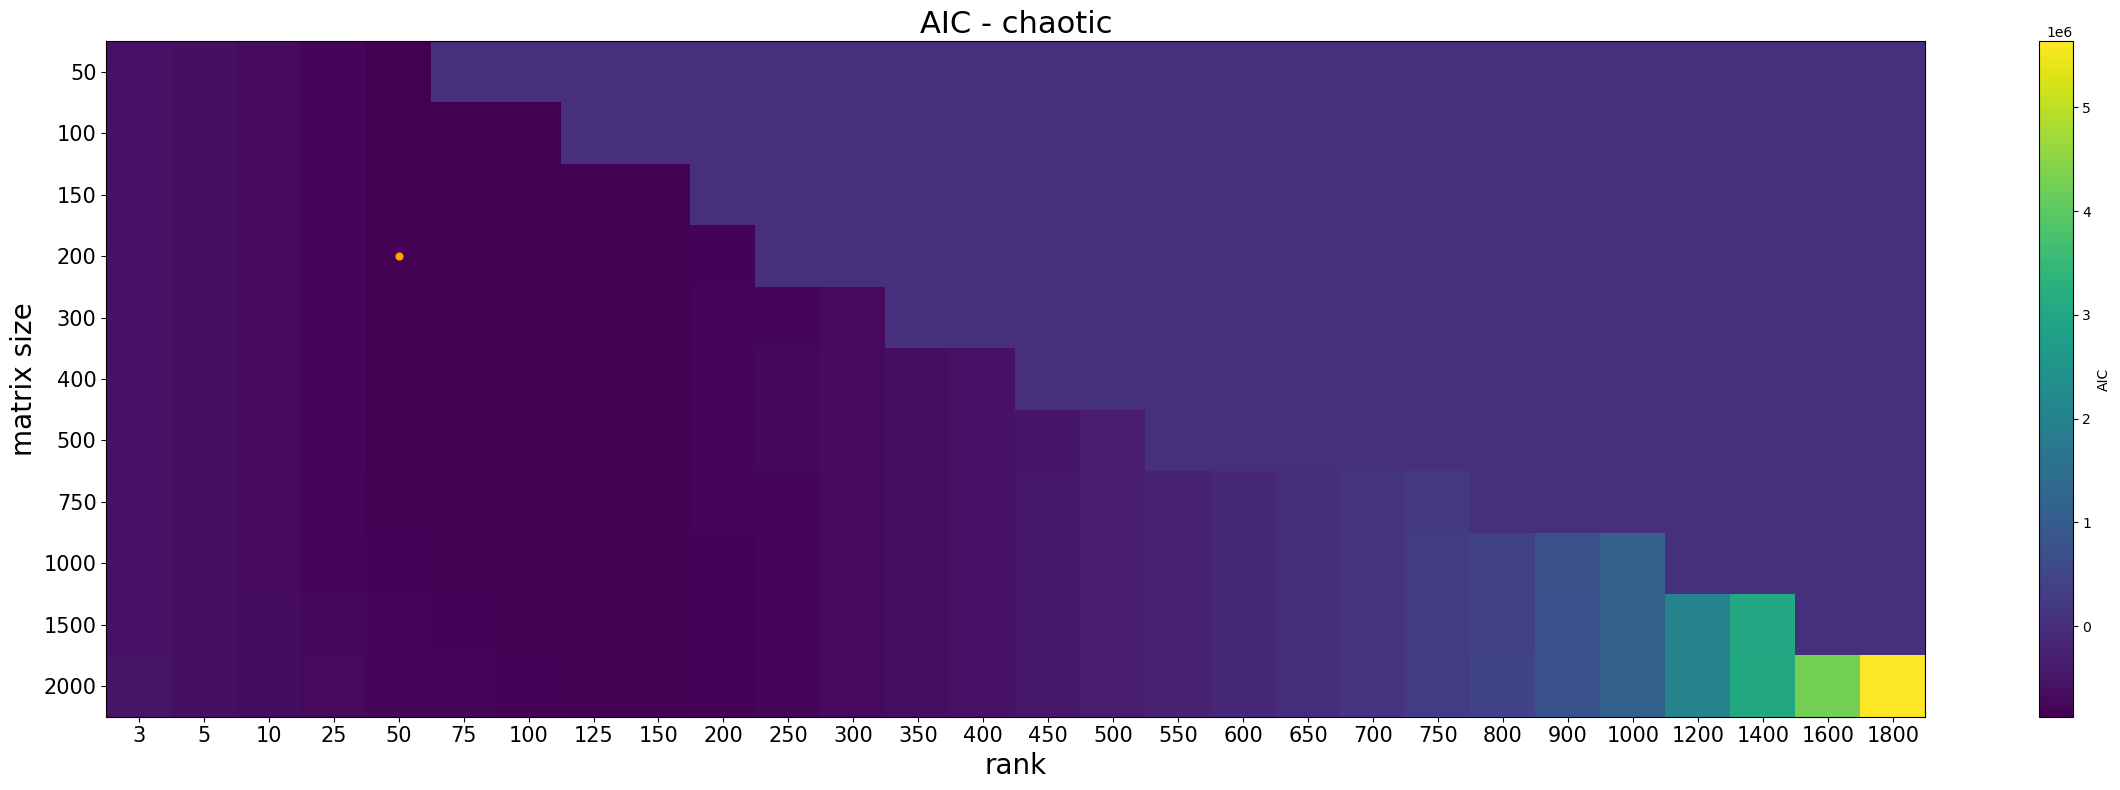

In [58]:
plt.figure(figsize=(24, 8))

norm = Normalize(vmin=AIC_mean.min(),vmax=AIC_mean.max())

plt.imshow(AIC_mean, norm=norm, aspect='auto')
plt.yticks(np.arange(len(matrix_size_vals)), [f"{matrix_size}" for matrix_size in matrix_size_vals])
plt.ylabel("matrix size", fontsize=20)
plt.xticks(np.arange(len(r_vals)), [f"{r}" for r in r_vals])
plt.xlabel('rank', fontsize=20)
ax = plt.gca()
ax.tick_params(labelsize=15)
ax.set_title(f'AIC - {system}', fontsize=22)
ax.scatter(t_index, m_index, c=picked_color, s=24)
plt.colorbar(ax=ax, label='AIC')

plt.tight_layout()
plt.show()

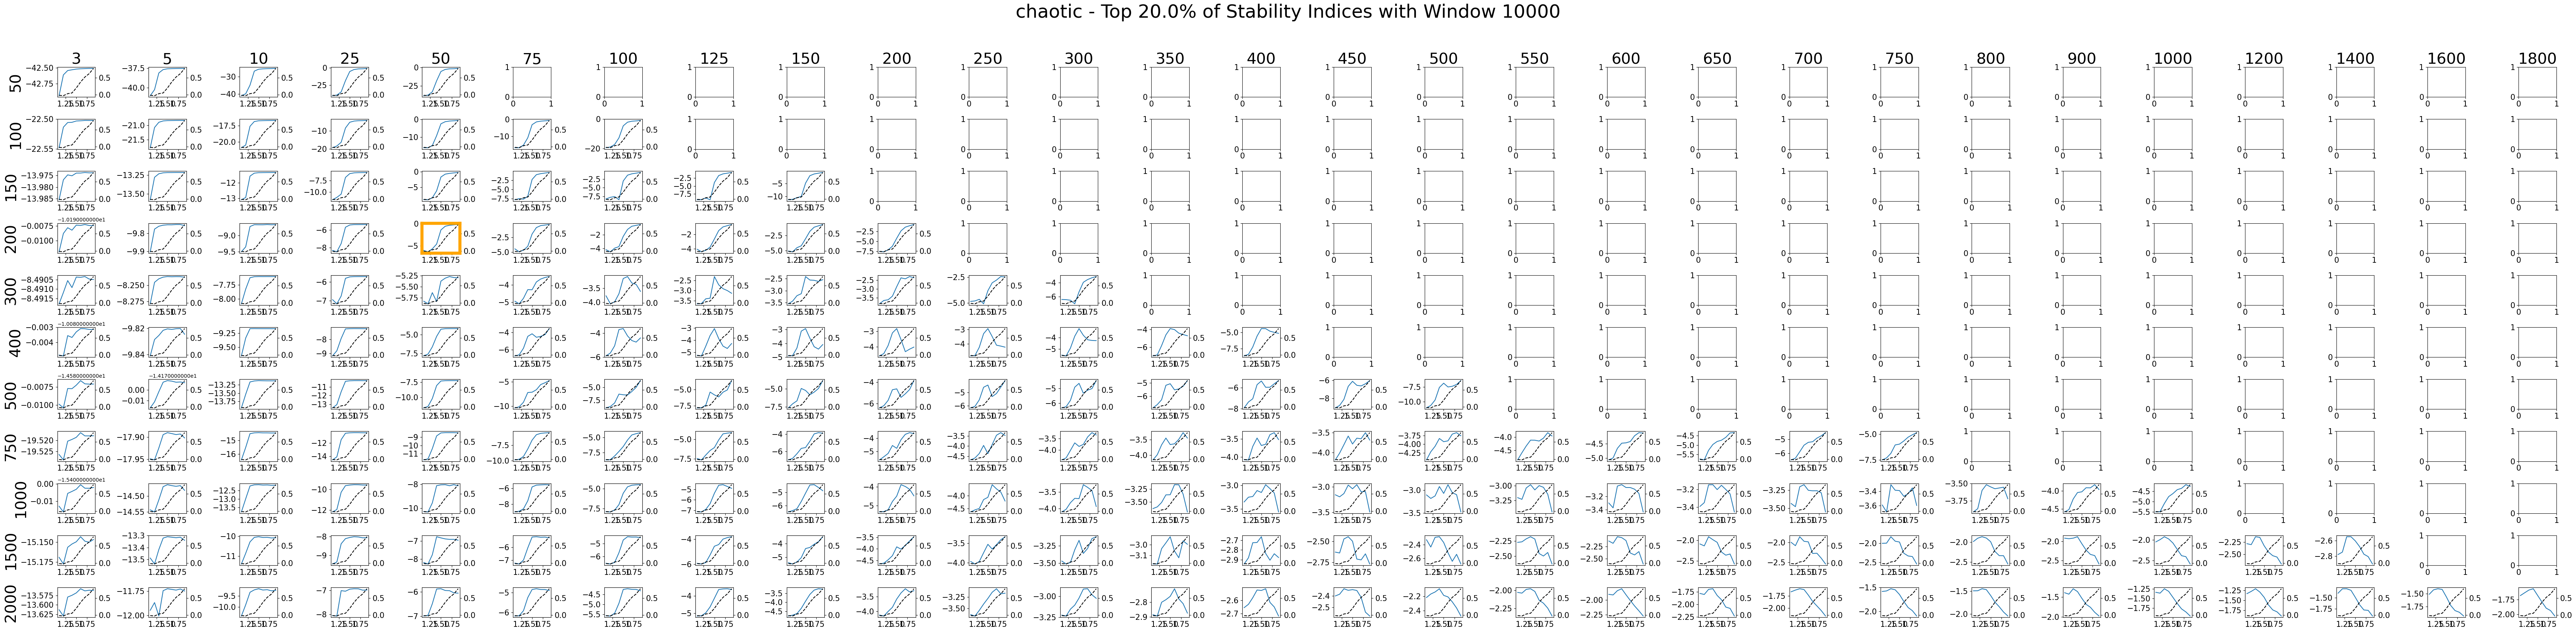

In [64]:
title_size = 30
label_size = 15
%matplotlib inline
fig, axs = plt.subplots(len(matrix_size_vals), len(r_vals), figsize=(70, 18))
for i, r in enumerate(r_vals):
    for j, matrix_size in enumerate(matrix_size_vals):
        ax = axs[j][i]
        if (matrix_size, r) in stab_curve.keys():
            if mean_stab_curve:
                ax.plot(keys[key_inds], stab_curve[(matrix_size, r)][key_inds])
                ax2 = ax.twinx()
                ax2.plot(keys[key_inds], true_vals, linestyle='--', c='k')

                ax2.tick_params(labelsize=label_size)
                if j == m_index and i == t_index:
                    for spine in ax2.spines.values():
                        spine.set_color(picked_color)
                        spine.set_linewidth(6)
            else:
                for ind, curve in enumerate(stab_curve[(matrix_size, r)]):
                    ax.plot(curve)
                
        if j == 0:
            ax.set_title(f'{r}', fontsize=title_size)
        if i == 0:
            ax.set_ylabel(f'{matrix_size}', fontsize=title_size)
        ax.tick_params(labelsize=label_size)
            
        if j == m_index and i == t_index:
            for spine in ax.spines.values():
                spine.set_color(picked_color)
                spine.set_linewidth(4)
            
#                 ax.spines['bottom'].set_color(picked_color)
#                 ax.spines['top'].set_color(picked_color) 
#                 ax.spines['right'].set_visible(False)
#                 ax.spines['left'].set_color(picked_color)

#                 ax2.spines['bottom'].set_color(picked_color)
#                 ax2.spines['top'].set_color(picked_color) 
#                 ax2.spines['right'].set_color(picked_color)
#                 ax2.spines['left'].set_visible(False)
            
        
plt.suptitle(f'{system} - Top {top_percent*100}% of Stability Indices with Window {window}', fontsize=36)
fig.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()